# Часть I (Теорема Байеса)

### Задание 1

Произошло убийство. На месте убийства найдена кровь, которая явно (будем считать, что с вероятностью 1) принадлежит настоящему убийце. Кровь принадлежит редкой группе, которая присутствует всего лишь у 1% населения. И так получилось, что у подсудимого как раз эта редкая группа крови!
Первым выходит прокурор и говорит: “Шанс, что у подсудимого была бы именно такая группа крови, если бы он был невиновен -- всего 1%; значит, с вероятностью 99% он виновен, предлагаю осудить”. В чём не прав прокурор? Укажите, какие вероятности он оценил, а какие должен был оценить.

#### Решение

Прокурор посчитал просто вероятность того, что у случайно выбранного человека именно такая группа крови, а попытался выдать ее за условную вероятность того, что подозреваемый имеет такую группу крови при условии невиновности. Именно ее он и должен был по-честному посчитать, и ,если бы она получилась маленькой, это вполне сошло бы за аргумент

### Задание 2

Затем выходит адвокат, объясняет ошибки прокурора и берёт слово сам: “В городе живёт миллион человек. Это значит, что примерно у 10000 из них такая группа крови. Значит, всё, что говорит нам эта кровь -- это то, что подсудимый совершил убийство с вероятностью 0.01%. Получается, что это свидетельство не просто не является строгим доказательством, а и вовсе даёт нам ничтожно малую вероятность того, что мой подзащитный виновен, так что предлагаю исключить его из материалов дела”. В чём не прав адвокат? Какие вероятности он оценил, а какие должен был оценить?

#### Решение

Адвокат посчитал вероятность того, что случайно выбранный человек с такой группой крови виновен в преступлении, т.е посчитал условную вероятность того, что человек виновен при условии того, что у него такая группа крови. Однако, из условия задачи - подсудимый уже был подозреваемым когда обнаружилась кровь. Поэтому нужно было посчитать условную вероятность виновности при условии _одновременно_ вероятности редкой группы крови и вероятности оказаться среди подозреваемых. Думаю, если получить больше данных, то эта вероятность сильно больше той, что назвал адвокат

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal
import numpy as np
matplotlib.rc('font',**{'family':'sans-serif'})

In [2]:
full_data = pd.read_csv('./data/owid-covid-data.csv', usecols=['iso_code', 'date', 'total_cases', 'new_cases'], parse_dates=['date'])
full_data[full_data.new_cases <= 0] = 1
full_data[full_data.total_cases <= 0] = 1

In [3]:
ru_data = full_data[full_data.iso_code == 'RUS'].drop('iso_code', axis=1)
ru_data = ru_data[(ru_data.date < pd.to_datetime('2020-05-31')) & (ru_data.date >= pd.to_datetime('2020-03-03'))].reset_index(drop=True)
train = ru_data[:50]
test = ru_data[50:]

In [4]:
X_train = np.array(train.index + 1)
train_dates = train.date.values[:50]
new_cases_train = train.new_cases.values
total_cases_train = train.total_cases.values
X_test = np.array(test.index + 1)
test_dates = test.date.values[:50]
new_cases_test = test.new_cases.values
total_cases_test = test.total_cases.values
full_dates = np.append(train_dates, test_dates)

# Часть II (Линейная регрессия)

### Задание 1. Линейная регрессия для обучения экспоненты

Обучать линейной регрессией экспоненту можно, например, прологарифмировав целевую переменную:

In [5]:
def predict_opt_sklearn_exp(x, _x_train=X_train, _y_train=total_cases_train):
    lr = LinearRegression()
    _x_train = _x_train.reshape(-1, 1)
    _y_train = _y_train.reshape(-1, 1)
    lr.fit(_x_train, np.log(_y_train))
    sigma_noise = np.std(np.log(_y_train) - lr.predict(_x_train))
    return np.exp(lr.predict(x.reshape(-1, 1))), np.exp(sigma_noise)

На датасете COVID:

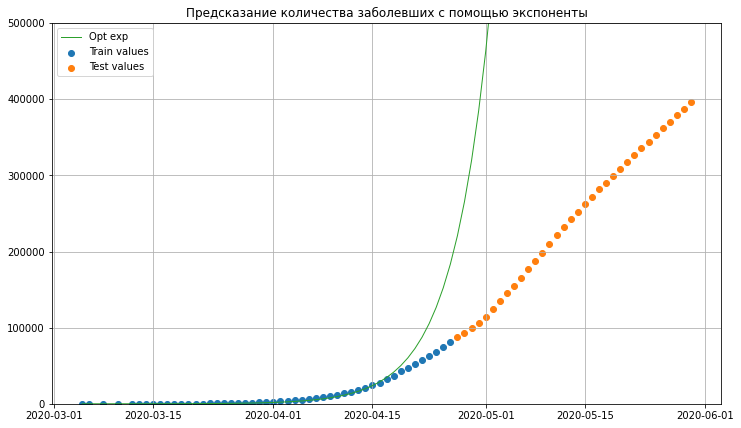

In [6]:
fig, ax = plt.subplots(figsize=(12, 7))
full_predict, sigma_noise = predict_opt_sklearn_exp(np.hstack([X_train,X_test])) 
ax.set_title('Предсказание количества заболевших с помощью экспоненты')
ax.scatter(train_dates, total_cases_train, c='tab:blue', label='Train values')
ax.scatter(test_dates, total_cases_test, c='tab:orange', label='Test values')
ax.plot(full_dates, full_predict, c='tab:green', linewidth=1, label='Opt exp')
ax.set_ylim(0, 500000)
ax.legend(loc='upper left')
ax.grid()

Если предположить априорное распределение параметров модели многомерным нормальным со средним $\mu_0$ и матрицей ковариации $\Sigma_0$, то апостериорное будет также нормальным, но с другими параметрами, вычисляемыми по формулам:

$$\Sigma ^{-1} = \Sigma_0^{-1} + \frac{1}{\sigma^{2}}X^{T}X$$

$$\mu = \Sigma(\Sigma_0^{-1}\mu_0 + \frac{1}{\sigma^{2}}X^{T}y)$$

In [7]:
def bayesian_update(mu, sigma, x_, y_, sigma_noise):
    x_ = np.vstack([np.ones(x_.shape[0]), x_]).T
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_), x_) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), mu) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_), y_))
    return mu_n, sigma_n

In [8]:
mu_n, sigma_n = bayesian_update(np.array([0, 0]), 2*np.eye(2), X_train, np.log(total_cases_train), sigma_noise)

In [9]:
def myplot_sample_exps(mu, sigma, n, points_tr, points_ts):
    xs = np.append(points_tr[0], points_ts[0])
    my_w = np.random.multivariate_normal(mu, sigma, n)
    plt.figure(figsize=(16, 9))
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.1)
        plt.ylim((0, 500000))
    plt.scatter(points_tr[0], points_tr[1], s=50, c='tab:blue')
    plt.scatter(points_ts[0], points_ts[1], s=50, c='tab:orange')    

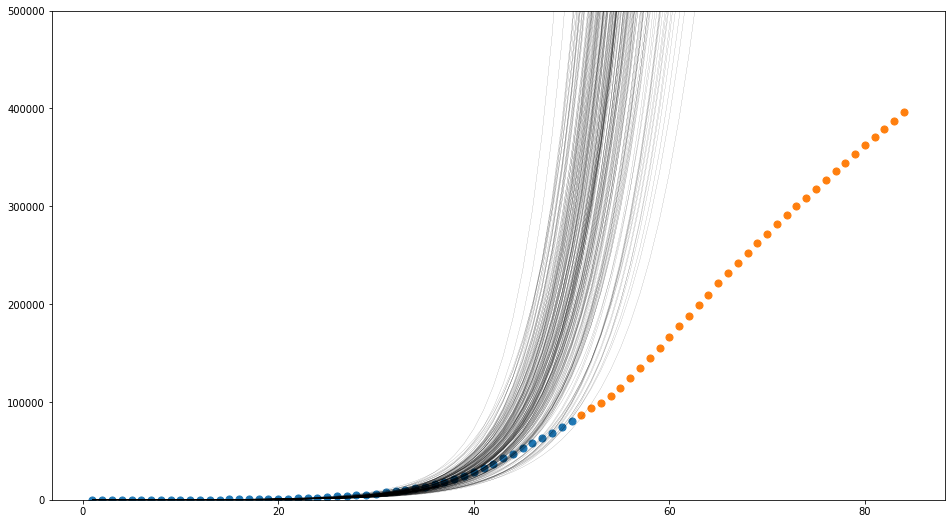

In [10]:
myplot_sample_exps(mu_n, sigma_n, 200, (X_train, total_cases_train), (X_test, total_cases_test))

In [11]:
def sample_predictions_by_dates(dates, mu, sigma, n=10):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for date in dates:
        x = (date - full_dates[0]).days
        preds = np.exp(my_w[:, 0] + my_w[:, 1] * x)
        plt.figure(figsize=(16, 9))
        bins = int(n / 2)
        plt.hist(preds, bins=bins)
        plt.title(f'Predict distribution to {date.date()}')
        print('-'*100)
        print(f'Predictions percentiles to {date.date()}')
        print('-'*100,'\n\n')
        print(f'Good scenario (q = 0.1): {int(np.percentile(preds, 0.1))}')
        print(f'Mean scenario (q = 0.5): {int(np.percentile(preds, 0.5))}')
        print(f'Bad scenario (q = 0.9): {int(np.percentile(preds, 0.9))}\n\n')                

----------------------------------------------------------------------------------------------------
Predictions percentiles to 2020-05-01
---------------------------------------------------------------------------------------------------- 


Good scenario (q = 0.1): 196458
Mean scenario (q = 0.5): 225308
Bad scenario (q = 0.9): 247434


----------------------------------------------------------------------------------------------------
Predictions percentiles to 2020-06-01
---------------------------------------------------------------------------------------------------- 


Good scenario (q = 0.1): 24707729
Mean scenario (q = 0.5): 30543058
Bad scenario (q = 0.9): 39965067


----------------------------------------------------------------------------------------------------
Predictions percentiles to 2020-06-09
---------------------------------------------------------------------------------------------------- 


Good scenario (q = 0.1): 86069032
Mean scenario (q = 0.5): 106691090
Ba

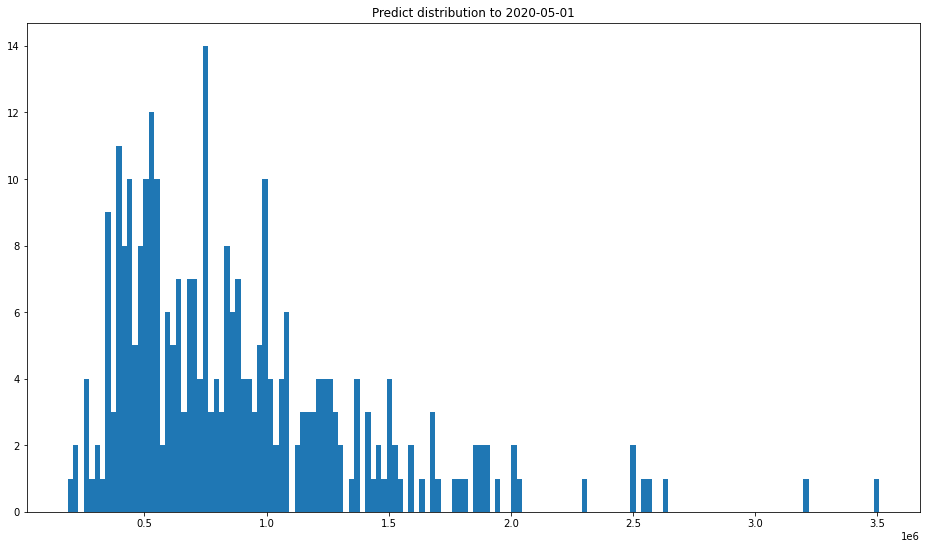

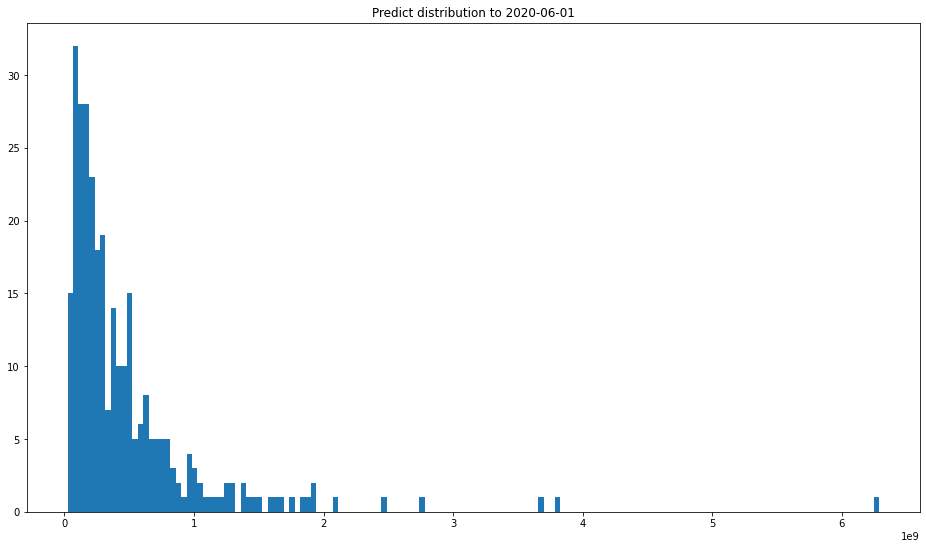

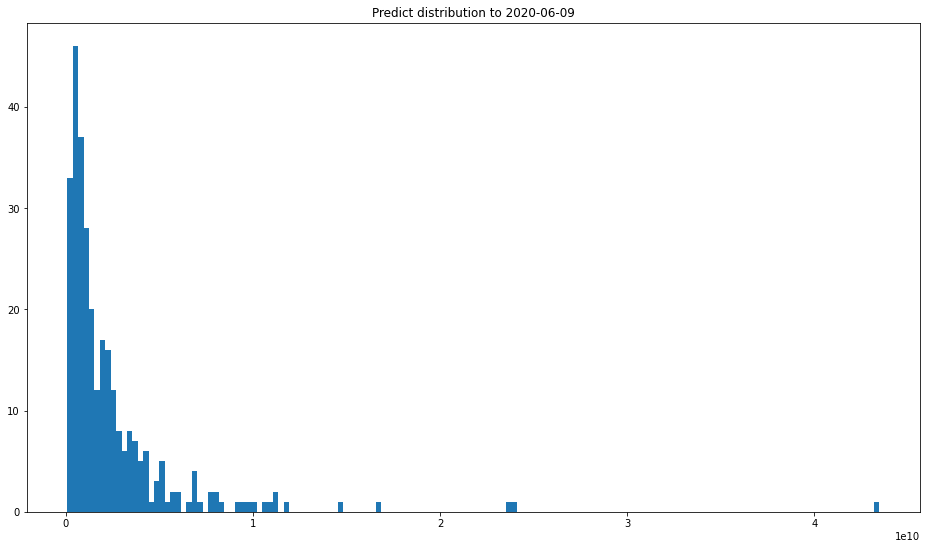

In [12]:
sample_predictions_by_dates([pd.to_datetime('2020-05-01'),
                             pd.to_datetime('2020-06-01'),
                             pd.to_datetime('2020-06-09'),
                            ], mu_n, sigma_n, 300)

Действительно грустно

### Задание 2. Линейная регрессия для обучения сигмоиды

##### Предлагаю следующий способ обучения сигмоиды

* Поскольку в датасете COVID данные обновляются посуточно, то функция новых случае выглядит как ступеньки (константа между любыми двумя соседними днями)

* Это позволяет не просто приблизить интеграл прямоугольниками, а прямо записать точное равенство:

$$ \int_a^{b}e^{-t^2}dt = e ^ {-t^2} * \delta t $$

* $\delta t = 1 $ - (если считать в днях)

* Тогда, можем обучать снова экспоненту, но от числа новых случаев.

* Total cases в таком случае - `np.cumsum`

In [13]:
def predict_opt_sklearn_sigmoid(x, _x_train, _y_train):
    lr = LinearRegression()
    _x_train = _x_train.reshape(-1, 1)
    _x_train = np.hstack([_x_train, _x_train ** 2])
    _y_train = _y_train.reshape(-1, 1)
    x = x.reshape(-1, 1)
    x = np.hstack([x, x ** 2])
    lr.fit(_x_train, np.log(_y_train))
    preds_log_newcases = lr.predict(x)
    preds_train_log_newcases = lr.predict(_x_train)
    preds_total_cases = np.cumsum(np.exp(preds_log_newcases))
    sigma_noise = np.std(np.log(_y_train) - preds_train_log_newcases)
    return preds_total_cases, np.exp(sigma_noise)

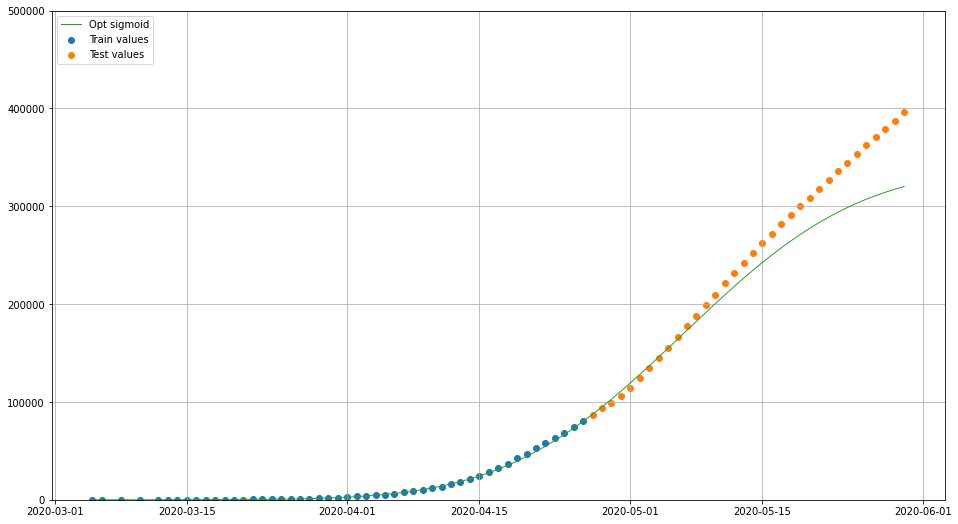

In [15]:
fig, ax = plt.subplots(figsize=(16, 9))
preds_sigm_total, sigma_noise_sigm = predict_opt_sklearn_sigmoid(np.append(X_train, X_test), X_train, new_cases_train)
ax.scatter(train_dates, total_cases_train, c='tab:blue', label='Train values')
ax.scatter(test_dates, total_cases_test, c='tab:orange', label='Test values')
ax.plot(full_dates, preds_sigm_total, c='tab:green', linewidth=1, label='Opt sigmoid')
ax.set_ylim(0, 500000)
ax.legend(loc='upper left')
ax.grid()

Байесовский шаг - аналогично

In [16]:
def bayesian_step_sigmoid(mu, sigma, x_, y_, sigma_noise):
    x_ = np.vstack([np.ones(x_.shape[0]), x_, x_ ** 2]).T
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_), x_) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), mu) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_), y_))
    return mu_n, sigma_n

In [17]:
mu_n, sigma_n = bayesian_step_sigmoid([0, 0, 0], 2 * np.eye(3), X_train, np.log(new_cases_train), sigma_noise_sigm)

In [18]:
def myplot_sample_sigm(mu, sigma, n, points_tr, points_ts):
    xs = np.append(points_tr[0], points_ts[0])
    my_w = np.random.multivariate_normal(mu, sigma, n)
    plt.figure(figsize=(16, 9))
    for w in my_w:
        plt.plot(xs, np.cumsum(np.exp(w[0] + w[1] * xs + w[2] * xs ** 2)), 'k-', lw=.1)
        plt.ylim((0, 500000))
    plt.scatter(points_tr[0], points_tr[1], s=50, c='tab:blue')
    plt.scatter(points_ts[0], points_ts[1], s=50, c='tab:orange')   

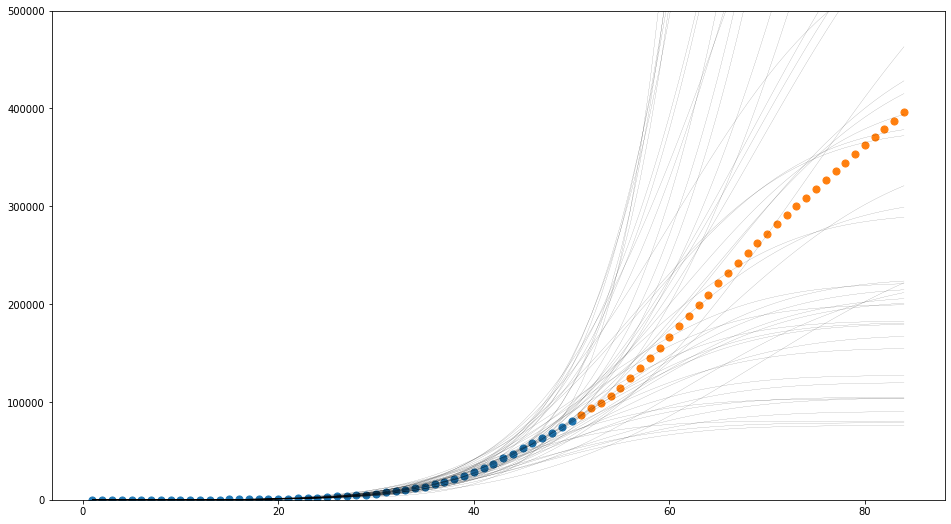

In [19]:
myplot_sample_sigm(mu_n, sigma_n, 50, (X_train, total_cases_train), (X_test, total_cases_test))

In [20]:
def sample_predictions_by_dates_sigm(dates, mu, sigma, new_cases_train, n=10):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for date in dates:
        x = np.arange(51, (date - full_dates[0]).days)
        preds = list()
        for w in my_w:
            new_cases = np.append(new_cases_train,np.exp(w[0] + w[1] * x + w[2] * x ** 2))
            preds.append(np.cumsum(new_cases)[-1])
        plt.figure(figsize=(16, 9))
        bins = int(n / 2)
        plt.hist(preds, bins=bins)
        plt.title(f'Predict distribution to {date.date()}')
        print('-'*100)
        print(f'Predictions percentiles to {date.date()}')
        print('-'*100,'\n\n')
        print(f'Good scenario (q = 0.1): {int(np.percentile(preds, 0.1))}')
        print(f'Mean scenario (q = 0.5): {int(np.percentile(preds, 0.5))}')
        print(f'Bad scenario (q = 0.9): {int(np.percentile(preds, 0.9))}\n\n')

----------------------------------------------------------------------------------------------------
Predictions percentiles to 2020-05-01
---------------------------------------------------------------------------------------------------- 


Good scenario (q = 0.1): 91312
Mean scenario (q = 0.5): 91344
Bad scenario (q = 0.9): 91376


----------------------------------------------------------------------------------------------------
Predictions percentiles to 2020-06-01
---------------------------------------------------------------------------------------------------- 


Good scenario (q = 0.1): 103236
Mean scenario (q = 0.5): 103664
Bad scenario (q = 0.9): 104091


----------------------------------------------------------------------------------------------------
Predictions percentiles to 2020-09-01
---------------------------------------------------------------------------------------------------- 


Good scenario (q = 0.1): 103249
Mean scenario (q = 0.5): 103680
Bad scenario (q 

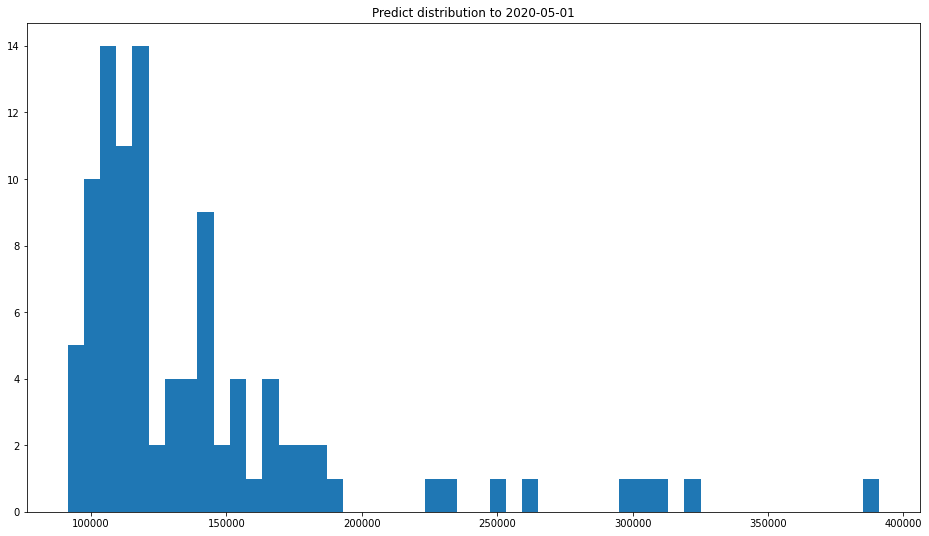

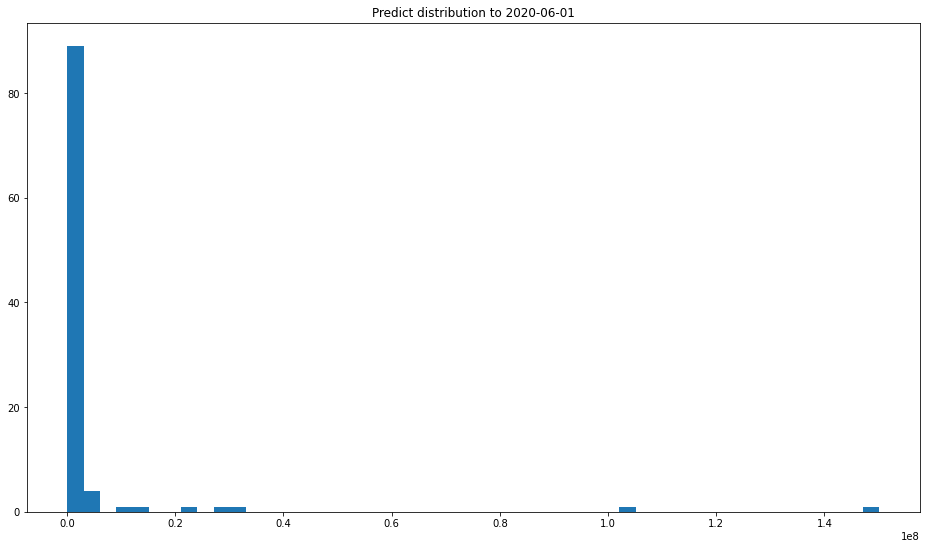

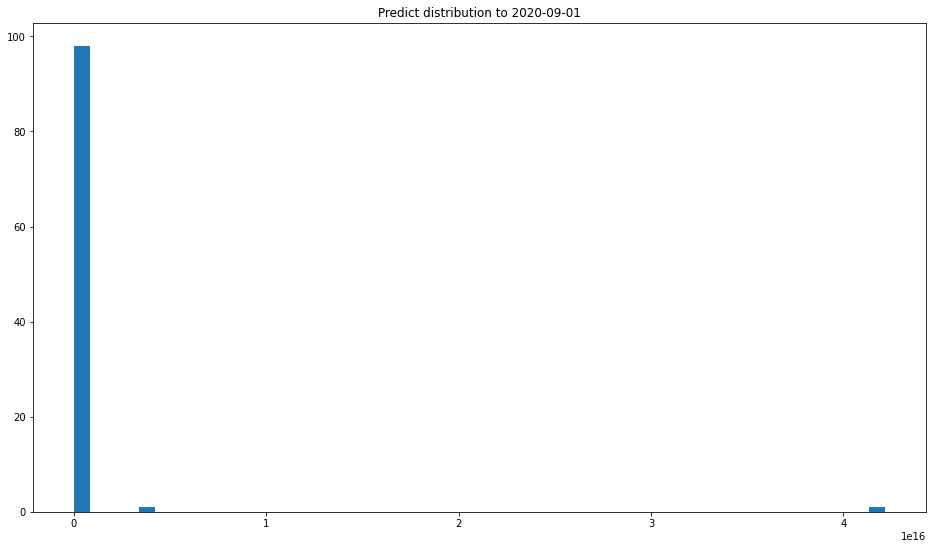

In [21]:
sample_predictions_by_dates_sigm([pd.to_datetime('2020-05-01'),
                                  pd.to_datetime('2020-06-01'),
                                  pd.to_datetime('2020-09-01'),],
                                 mu_n, sigma_n, new_cases_train, 100)